<a href="https://colab.research.google.com/github/viraatdas/3D-Machine-Learning/blob/master/Deep_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf /root/tensorflow_datasets/downloads

In [6]:
# colab link: https://colab.research.google.com/drive/1_gpJGU9FfgdVJlIcQNBiQhZXgT7fHTVN?usp=sharing
import tensorflow_datasets as tfds
import tensorflow as tf

In [7]:
dataset, info = tfds.load('cityscapes', download_and_prepare_kwargs={"download_config":tfds.download.DownloadConfig(manual_dir="/content/drive/My Drive/Cityscapes")}, with_info=True)

ExtractError: ignored

In [ ]:
dataset

NameError: ignored

In [ ]:

# normalize images to [0,1]
# segmentation masks are labeled
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image_left'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_label'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image_left'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_label'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
# take a look at the image and the corresponding mask
import matplotlib.pyplot as plt
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

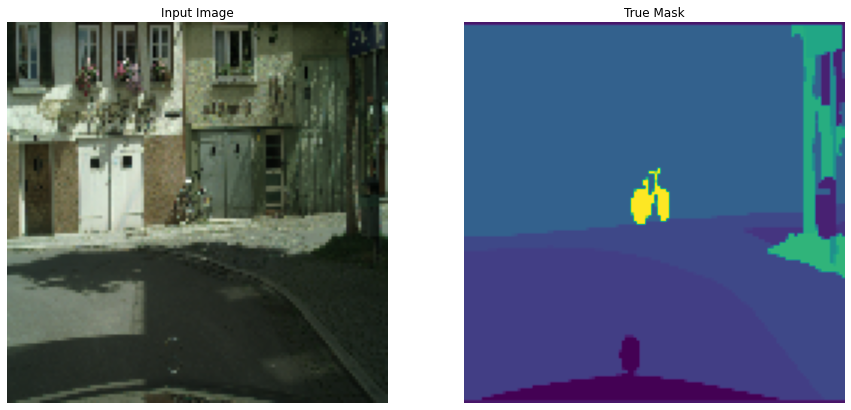

In [ ]:
i = 0
for image, mask in train.take(1):
  if i == 1:
    break
  sample_image, sample_mask = image, mask
  i+=1
display([sample_image, sample_mask])

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, BatchNormalization, Input, Conv2DTranspose, concatenate, UpSampling2D, Dropout

def conv_block(inp, filters, name, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal'):
    '''
    Convolutional block with 2 convolutional layers
    '''
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=kernel_initializer, name='conv'+name+'a')(inp)
    x = BatchNormalization(name='batch'+name+'a')(x)
    x = Activation('relu', name='activation'+name+'a')(x)
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, kernel_initializer=kernel_initializer, name='conv'+name+'b')(x)
    x = BatchNormalization(name='batch'+name+'b')(x)
    x = Activation('relu', name='activation'+name+'b')(x)
    return x


def pool_block(inp, pool_size, strides, name):
    pool = MaxPool2D(pool_size=pool_size, strides=strides, name='pool'+name)(inp)
    return pool

def upscale_block(inp, skip, filters, name, kernel_size=2, strides=2, kernel_initializer='he_normal'):
    '''
    Upscale block with Conv2dtranspose
    '''
    x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, name='transpose'+name)(inp)
    x = concatenate([skip, x], name='concate'+name)
    return x

def unet_model(H, W, classes):
    inp = Input((H, W, 3), name='input')

    conv1 = conv_block(inp, 64, '1')
    skip1 = conv1
    conv1 = pool_block(conv1, 2, 2, '1')

    conv2 = conv_block(conv1, 128, '2')
    skip2 = conv2
    conv2 = pool_block(conv2, 2, 2, '2')

    conv3 = conv_block(conv2, 256, '3')
    skip3 = conv3
    conv3 = pool_block(conv3, 2, 2, '3')

    conv4 = conv_block(conv3, 512, '4')
    skip4 = conv4
    conv4 = pool_block(conv4, 2, 2, '4')

    conv5 = conv_block(conv4, 1024, '5')

    conv6 = conv_block(conv5, 512, '6')
    conv6 = upscale_block(conv6, skip4, 512, '1')

    conv7 = conv_block(conv6, 256, '7')
    conv7 = upscale_block(conv7, skip3, 256, '2')

    conv8 = conv_block(conv7, 128, '8')
    conv8 = upscale_block(conv8, skip2, 128, '3')

    conv9 = conv_block(conv8, 64, '9')
    conv9 = upscale_block(conv9, skip1, 64, '4')
    conv9 = conv_block(conv9, 64, '10')

    if classes == 1:
        conv9 = Conv2D(classes, 1, padding='same', activation='sigmoid', kernel_initializer='he_normal', name='conv11')(conv9)
    else:
        conv9 = Conv2D(classes, 1, padding='same', activation='softmax', kernel_initializer='he_normal', name='conv11')(conv9)

    model = Model(inp, conv9, name='unet_'+str(classes))
    model.save('unet_' + str(classes) + '.h5')
    print('Loading UNET')

    return model

In [ ]:
model = unet_model(128,128,3)
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
def dice_loss(pred, actual):
    num = 2 * tf.reduce_sum((pred * actual), axis=-1)
    den = tf.reduce_sum((pred + actual), axis=-1)
    return 1 - (num + 1) / (den + 1)

import tensorflow as tf
with tf.device('/device:GPU:0'):
    model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), 
                    loss = dice_loss, 
                    metrics = ['accuracy'])

Loading UNET


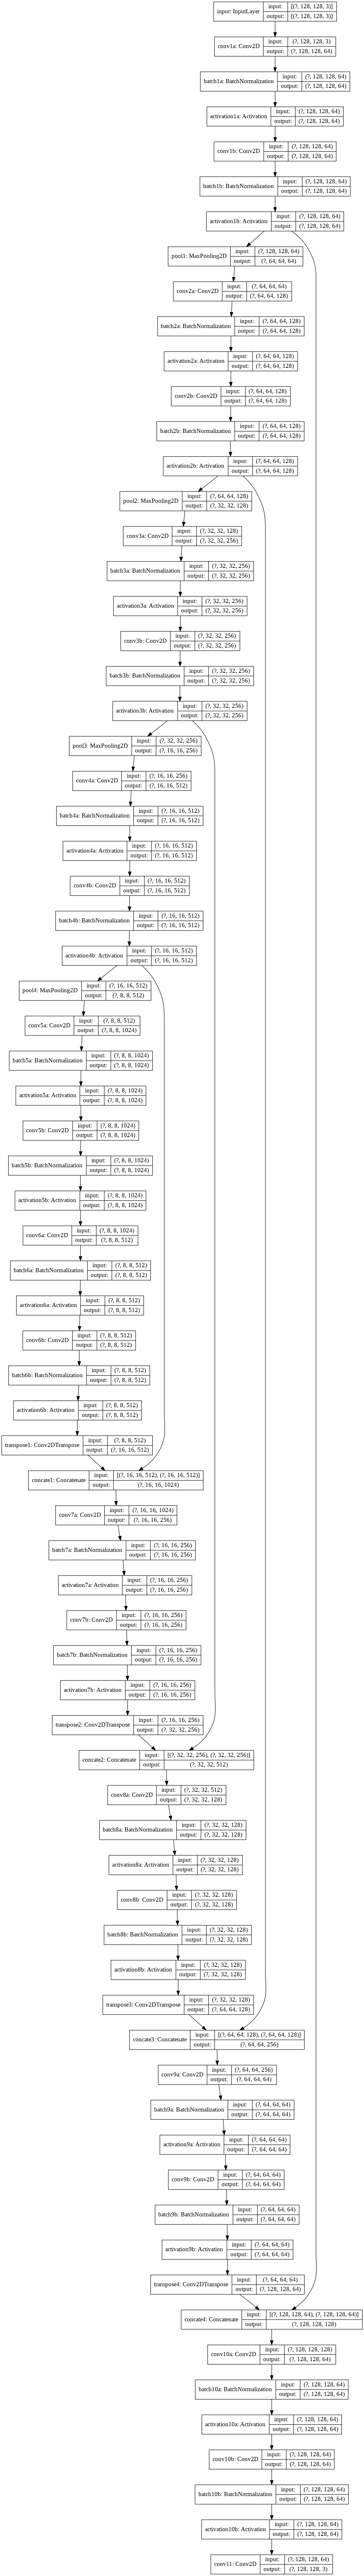

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
  

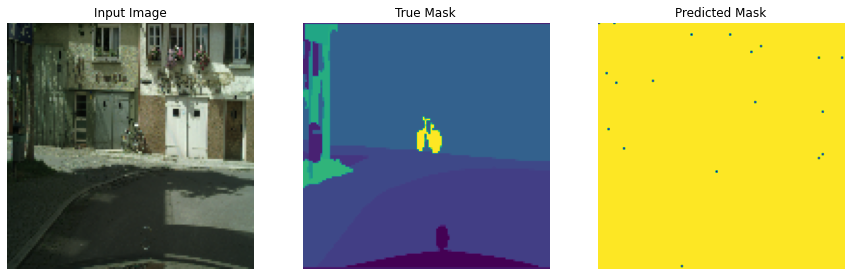

In [ ]:
show_predictions()

Observe how the model changes while training

In [ ]:
from IPython.display import clear_output


class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

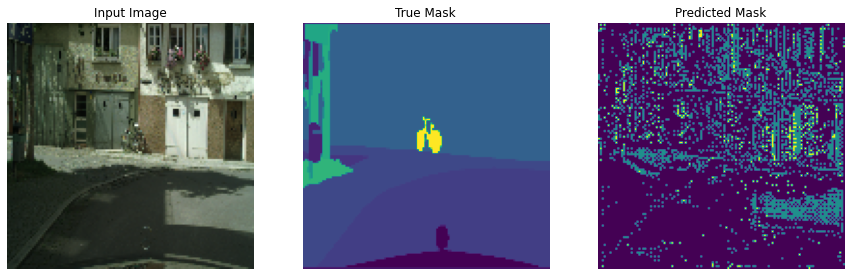


Sample Prediction after epoch 20

46/46 [==============================] - 49s 1s/step - loss: 0.3529 - accuracy: 0.0406 - val_loss: 0.0318 - val_accuracy: 0.0393


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

with tf.device('/device:GPU:0'):

  model_history = model.fit(train_dataset, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            validation_steps=VALIDATION_STEPS,
                            validation_data=test_dataset,
                            callbacks=[DisplayCallback()],
                            workers=16,
                          use_multiprocessing=True)
print(model_history)

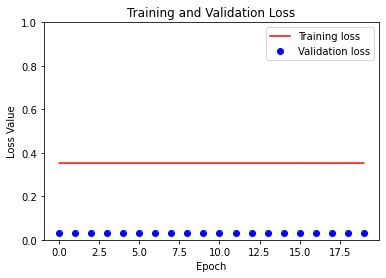

In [ ]:
import matplotlib.pyplot as plt
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

Modifying model

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, BatchNormalization, Input, Conv2DTranspose, concatenate, UpSampling2D, Dropout




def unet_modified_model(H, W, classes):
    inp = Input((H, W, 3), name='input')

    conv1 = conv_block(inp, 64, '1')
    skip1 = conv1
    conv1 = pool_block(conv1, 3, 3, '1')

    conv2 = conv_block(conv1, 128, '2')
    skip2 = conv2
    conv2 = pool_block(conv2, 3, 3, '2')

    conv3 = conv_block(conv2, 256, '3')
    skip3 = conv3
    conv3 = pool_block(conv3, 3, 3, '3')

    # conv4 = conv_block(conv3, 512, '4')
    conv4 = conv_block(conv3, 128, '4')
    skip4 = conv4
    conv4 = pool_block(conv4, 3, 3, '4')

    conv5 = conv_block(conv4, 1024, '5')

    conv6 = conv_block(conv5, 512, '6')
    conv6 = upscale_block(conv6, skip4, 512, '1')

    # conv7 = conv_block(conv6, 256, '7')
    # conv7 = upscale_block(conv7, skip3, 256, '2')

    conv8 = conv_block(conv6, 128, '8')
    conv8 = upscale_block(conv8, skip2, 128, '3')

    conv9 = conv_block(conv8, 64, '9')
    conv9 = upscale_block(conv9, skip1, 64, '4')
    conv9 = conv_block(conv9, 64, '10')

    dense = layers.Dense()

    if classes == 1:
        conv9 = Conv2D(classes, 1, padding='same', activation='sigmoid', kernel_initializer='he_normal', name='conv11')(conv9)
    else:
        conv9 = Conv2D(classes, 1, padding='same', activation='softmax', kernel_initializer='he_normal', name='conv11')(conv9)

    model = Model(inp, conv9, name='unet_'+str(classes))
    model.save('unet_' + str(classes) + '.h5')
    print('Loading UNET')

    return model

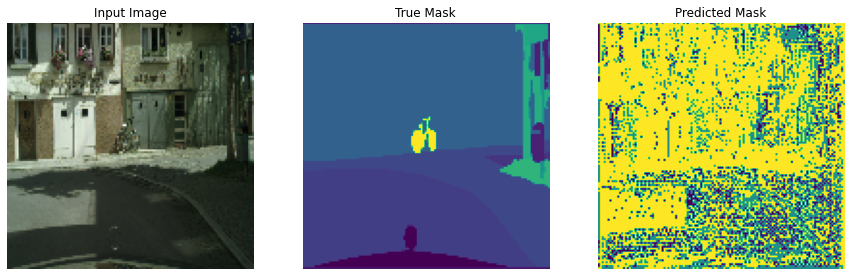


Sample Prediction after epoch 20

46/46 [==============================] - 47s 1s/step - loss: 0.3528 - accuracy: 0.0158 - val_loss: 0.0318 - val_accuracy: 0.0147


In [ ]:
model = unet_model(128,128,3)

with tf.device('/device:GPU:0'):
    model.compile(optimizer = tf.keras.optimizers.Adam(0.0001), 
                    loss = dice_loss, 
                    metrics = ['accuracy'])

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

with tf.device('/device:GPU:0'):

  model_history = model.fit(train_dataset, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            validation_steps=VALIDATION_STEPS,
                            validation_data=test_dataset,
                            callbacks=[DisplayCallback()],
                          use_multiprocessing=True)
print(model_history)

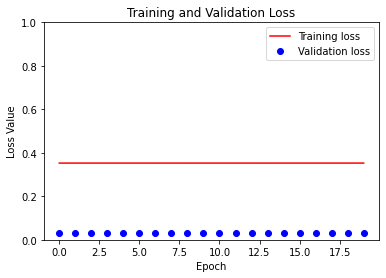

In [ ]:
import matplotlib.pyplot as plt
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()